# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [2]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize

In [4]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 8
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [5]:
HOC_NUM = 2
DATA_SZ = -1
# train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
# utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

X, y, ast_maps = utils.load_dataset_predict_ast_using_embeddings(hoc_num=HOC_NUM, data_sz=DATA_SZ)

Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (2299, 8, 220)
220
2314
Inputs and targets done!


In [6]:
num_traj, num_timesteps, embed_dim = X.shape

X_train = X[0:7*num_traj/8]
X_val =  X[7*num_traj/8: 15*num_traj/16 ]
X_test = X[15*num_traj/16:num_traj]

y_train = y[0:7*num_traj/8]
y_val =  y[7*num_traj/8: 15*num_traj/16]
y_test = y[15*num_traj/16:num_traj]

train_data = X_train, y_train
val_data = X_val, y_val
test_data = X_test, y_test
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape

(2011, 7, 256)
(2011, 7)
(144, 7, 256)
(144, 7, 256)


In [7]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, embed_dim, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [8]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 496
Ep 0 	iter 1  	loss 5.55062, train acc 0.00, train corr acc 0.00, val acc 71.13, val corr acc 31.68
Ep 0 	iter 2  	loss 5.18767, train acc 67.41, train corr acc 30.77, val acc 72.02, val corr acc 33.57
Ep 0 	iter 3  	loss 3.32195, train acc 70.54, train corr acc 31.25, val acc 72.12, val corr acc 34.04
Ep 0 	iter 4  	loss 1.76084, train acc 71.88, train corr acc 32.26, val acc 71.63, val corr acc 32.86
Ep 0 	iter 5  	loss 1.12867, train acc 75.89, train corr acc 37.21, val acc 71.63, val corr acc 32.86
Ep 0 	iter 6  	loss 1.37989, train acc 73.66, train corr acc 34.44, val acc 71.63, val corr acc 32.86
Ep 0 	iter 7  	loss 1.43043, train acc 73.21, train corr acc 34.07, val acc 71.63, val corr acc 32.86
Ep 0 	iter 8  	loss 1.13268, train acc 76.34, train corr acc 38.10, val acc 71.63, val corr acc 32.86
Ep 0 	iter 9  	loss 1.38555, train acc 74.55, train corr acc 35.96, val acc 71.53, val corr acc 32.62
Ep 0 	iter 10  	loss 1.70656, tr

In [13]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')

Testing...
Final results:
  test loss:			0.849197
  test raw accuracy:		79.46 %
  test corrected accuracy:	51.55 %


In [15]:
# Convert to AST IDs so we can look at the AST json files
traj_row_to_ast_id_map = ast_maps['traj_row_to_id']
X_test, y_test = test_data
y_test_ast_ids = utils.convert_truth_to_ast_ids(y_test, traj_row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, traj_row_to_ast_id_map)

print ("Truth AST IDs")
print y_test_ast_ids[10:30, :]
print("Predicted AST IDs")
print pred_test_ast_ids[10:30,:]

Truth AST IDs
[[  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  6.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 17.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  8.   5.   0.  -1.  -1.  -1.  -1.]
 [  8.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 48.   0.  -1.  -1.  -1.  -1.  -1.]
 [  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 23.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 44.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  22.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 13.  -1.  -1.  -1.  -1.  -1.  -1.]]
Predicted AST IDs
[[  2.   0.   0.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [  5.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.  -1.  -1. 

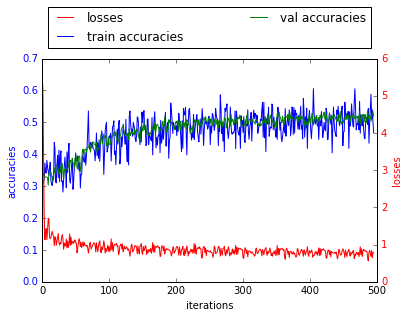

In [16]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

Below are more trial runs

In [17]:
def full_train_test_run(hoc_num, data_sz=-1):
    train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
            utils.load_dataset_predict_ast(hoc_num=hoc_num, data_sz=data_sz)
    
    # create model
    train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, \
                                                                 grad_clip, dropout_p, num_lstm_layers)
    # Training!
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, \
        val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)
    # Evaluate on test set
    test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, \
                                              row_to_ast_id_map, dataset_name='test')
    # Visualize the loss and the accuracies for both training and validation sets for each epoch
    num_train = train_data[0].shape[0]
    visualize.plot_loss_acc('hoc'+ str(hoc_num) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')  


Training and testing predict_next_ast rnn on Hour of Code problem #1
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (1322, 7, 195)
X_train shape (1156, 6, 195)
y_train shape (1156, 6)
X_val shape (83, 6, 195)
X_test shape (83, 6, 195)
num_timesteps 6
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 288
Ep 0 	iter 1  	loss 5.27918, train acc 0.00, train corr acc 0.00, val acc 61.24, val corr acc 17.52
Ep 0 	iter 2  	loss 5.13821, train acc 65.10, train corr acc 19.28, val acc 70.68, val corr acc 37.61
Ep 0 	iter 3  	loss 4.68521, train acc 72.92, train corr acc 39.53, val acc 69.28, val corr acc 34.62
Ep 0 	iter 4  	loss 3.14792, train acc 70.31, train corr acc 36.67, val acc 69.48, val corr acc 35.04
Ep 0 	iter 5  	loss 1.86376, train acc 68.75, train corr acc 34.78, val acc 69.48, val corr acc 35.04
Ep 0 	iter 6  	loss 1.29971, train acc 77.08, 

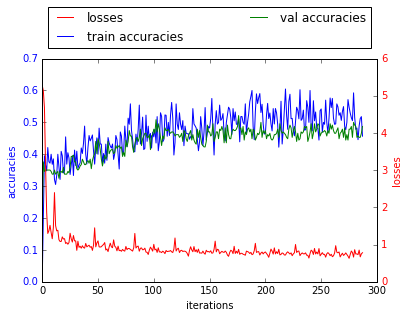

Training and testing predict_next_ast rnn on Hour of Code problem #2
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (2299, 8, 220)
X_train shape (2011, 7, 220)
y_train shape (2011, 7)
X_val shape (144, 7, 220)
X_test shape (144, 7, 220)
num_timesteps 7
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 496
Ep 0 	iter 1  	loss 5.39392, train acc 0.00, train corr acc 0.00, val acc 73.51, val corr acc 36.73
Ep 0 	iter 2  	loss 5.21366, train acc 73.21, train corr acc 39.39, val acc 73.21, val corr acc 36.02
Ep 0 	iter 3  	loss 4.34380, train acc 75.00, train corr acc 39.13, val acc 72.32, val corr acc 33.89
Ep 0 	iter 4  	loss 2.49415, train acc 71.88, train corr acc 33.68, val acc 72.42, val corr acc 34.12
Ep 0 	iter 5  	loss 1.51831, train acc 73.21, train corr acc 34.78, val acc 72.42, val corr acc 34.12
Ep 0 	iter 6  	loss 1.54770, train acc 70.54

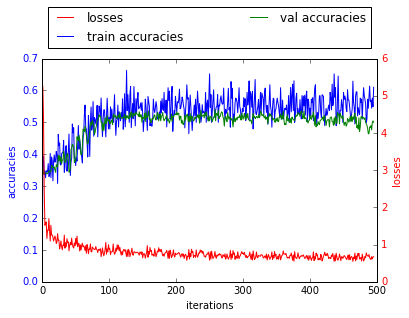

Training and testing predict_next_ast rnn on Hour of Code problem #3
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (4436, 7, 218)
X_train shape (3881, 6, 218)
y_train shape (3881, 6)
X_val shape (277, 6, 218)
X_test shape (278, 6, 218)
num_timesteps 6
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 968
Ep 0 	iter 1  	loss 5.38370, train acc 0.52, train corr acc 0.88, val acc 60.47, val corr acc 37.13
Ep 0 	iter 2  	loss 5.25585, train acc 60.94, train corr acc 34.21, val acc 55.05, val corr acc 28.52
Ep 0 	iter 3  	loss 4.72805, train acc 59.38, train corr acc 30.97, val acc 53.91, val corr acc 26.70
Ep 0 	iter 4  	loss 3.16095, train acc 55.73, train corr acc 26.09, val acc 53.73, val corr acc 26.41
Ep 0 	iter 5  	loss 1.89166, train acc 59.90, train corr acc 29.36, val acc 53.73, val corr acc 26.41
Ep 0 	iter 6  	loss 1.94001, train acc 54.17

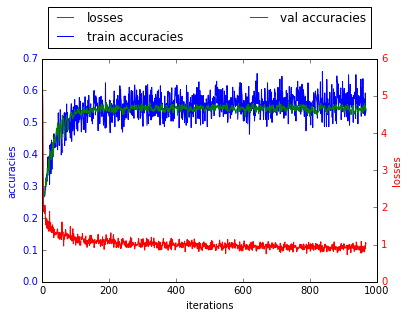

Training and testing predict_next_ast rnn on Hour of Code problem #4
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (5759, 9, 246)
X_train shape (5039, 8, 246)
y_train shape (5039, 8)
X_val shape (360, 8, 246)
X_test shape (360, 8, 246)
num_timesteps 8
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 1256
Ep 0 	iter 1  	loss 5.50929, train acc 0.39, train corr acc 0.82, val acc 70.90, val corr acc 36.93
Ep 0 	iter 2  	loss 5.33491, train acc 71.48, train corr acc 39.67, val acc 67.85, val corr acc 30.22
Ep 0 	iter 3  	loss 4.45810, train acc 68.36, train corr acc 32.50, val acc 66.46, val corr acc 27.20
Ep 0 	iter 4  	loss 2.53770, train acc 66.02, train corr acc 26.89, val acc 66.39, val corr acc 27.05
Ep 0 	iter 5  	loss 1.71534, train acc 65.23, train corr acc 26.45, val acc 66.42, val corr acc 27.13
Ep 0 	iter 6  	loss 1.52838, train acc 66.4

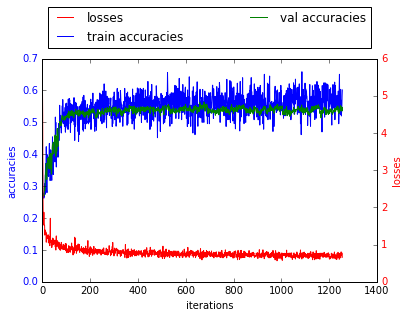

Training and testing predict_next_ast rnn on Hour of Code problem #5
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (10058, 11, 631)
X_train shape (8800, 10, 631)
y_train shape (8800, 10)
X_val shape (629, 10, 631)
X_test shape (629, 10, 631)
num_timesteps 10
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 2200
Ep 0 	iter 1  	loss 6.45232, train acc 0.00, train corr acc 0.00, val acc 75.93, val corr acc 35.05
Ep 0 	iter 2  	loss 6.22230, train acc 77.81, train corr acc 38.79, val acc 73.18, val corr acc 27.63
Ep 0 	iter 3  	loss 4.76609, train acc 76.88, train corr acc 30.84, val acc 72.96, val corr acc 27.03
Ep 0 	iter 4  	loss 2.53197, train acc 76.25, train corr acc 29.63, val acc 72.94, val corr acc 26.98
Ep 0 	iter 5  	loss 1.81094, train acc 69.69, train corr acc 24.81, val acc 72.94, val corr acc 26.98
Ep 0 	iter 6  	loss 1.46837, train a

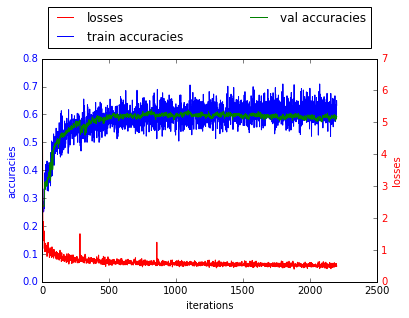

Training and testing predict_next_ast rnn on Hour of Code problem #6
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (1529, 6, 271)
X_train shape (1337, 5, 271)
y_train shape (1337, 5)
X_val shape (96, 5, 271)
X_test shape (96, 5, 271)
num_timesteps 5
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 328
Ep 0 	iter 1  	loss 5.60659, train acc 0.00, train corr acc 0.00, val acc 70.42, val corr acc 37.44
Ep 0 	iter 2  	loss 5.46780, train acc 70.62, train corr acc 38.16, val acc 74.58, val corr acc 46.26
Ep 0 	iter 3  	loss 5.04437, train acc 73.75, train corr acc 45.45, val acc 73.33, val corr acc 43.61
Ep 0 	iter 4  	loss 3.68444, train acc 68.75, train corr acc 39.02, val acc 72.71, val corr acc 42.29
Ep 0 	iter 5  	loss 2.32955, train acc 60.00, train corr acc 33.33, val acc 72.71, val corr acc 42.29
Ep 0 	iter 6  	loss 1.76798, train acc 68.12, 

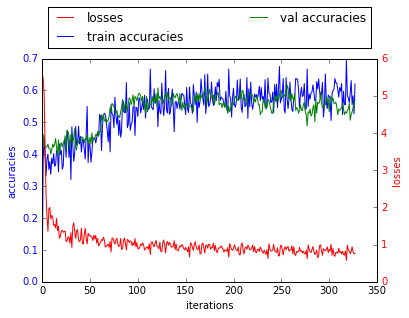

Training and testing predict_next_ast rnn on Hour of Code problem #7
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (4195, 7, 432)
X_train shape (3670, 6, 432)
y_train shape (3670, 6)
X_val shape (262, 6, 432)
X_test shape (263, 6, 432)
num_timesteps 6
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 912
Ep 0 	iter 1  	loss 6.06657, train acc 0.00, train corr acc 0.00, val acc 63.10, val corr acc 29.95
Ep 0 	iter 2  	loss 5.93804, train acc 63.54, train corr acc 28.57, val acc 64.69, val corr acc 32.97
Ep 0 	iter 3  	loss 5.52438, train acc 61.46, train corr acc 31.48, val acc 63.99, val corr acc 31.64
Ep 0 	iter 4  	loss 3.78256, train acc 60.94, train corr acc 29.91, val acc 63.99, val corr acc 31.64
Ep 0 	iter 5  	loss 2.53652, train acc 61.98, train corr acc 30.48, val acc 63.99, val corr acc 31.64
Ep 0 	iter 6  	loss 2.14587, train acc 58.85

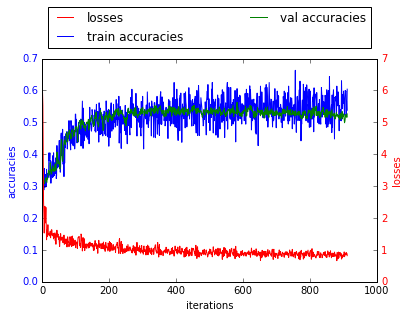

Training and testing predict_next_ast rnn on Hour of Code problem #8
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (6402, 6, 924)
X_train shape (5601, 5, 924)
y_train shape (5601, 5)
X_val shape (400, 5, 924)
X_test shape (401, 5, 924)
num_timesteps 5
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 1400
Ep 0 	iter 1  	loss 6.82889, train acc 0.00, train corr acc 0.00, val acc 57.25, val corr acc 25.91
Ep 0 	iter 2  	loss 6.72915, train acc 60.00, train corr acc 23.81, val acc 62.70, val corr acc 35.36
Ep 0 	iter 3  	loss 6.47124, train acc 63.75, train corr acc 36.96, val acc 62.25, val corr acc 34.58
Ep 0 	iter 4  	loss 5.46258, train acc 55.00, train corr acc 30.77, val acc 62.15, val corr acc 34.40
Ep 0 	iter 5  	loss 3.30170, train acc 63.75, train corr acc 35.56, val acc 62.15, val corr acc 34.40
Ep 0 	iter 6  	loss 2.62131, train acc 63.1

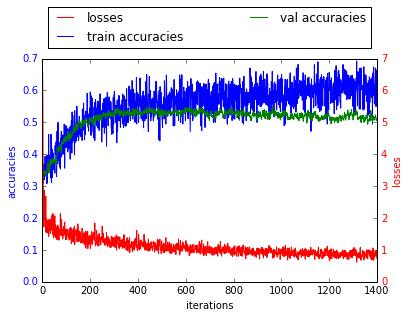

Training and testing predict_next_ast rnn on Hour of Code problem #9
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
X_train shape (10783, 5, 2042)
y_train shape (10783, 5)
X_val shape (770, 5, 2042)
X_test shape (771, 5, 2042)
num_timesteps 5
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 2688
Ep 0 	iter 1  	loss 7.62428, train acc 0.00, train corr acc 0.00, val acc 55.43, val corr acc 16.90
Ep 0 	iter 2  	loss 7.54065, train acc 49.38, train corr acc 14.74, val acc 66.29, val corr acc 37.14
Ep 0 	iter 3  	loss 7.22501, train acc 65.00, train corr acc 35.63, val acc 66.31, val corr acc 37.19
Ep 0 	iter 4  	loss 6.24642, train acc 60.62, train corr acc 33.68, val acc 66.31, val corr acc 37.19
Ep 0 	iter 5  	loss 4.04771, train acc 59.38, train corr acc 32.29, val acc 66.31, val corr acc 37.19
Ep 0 	iter 6  	loss 2.47845, train a

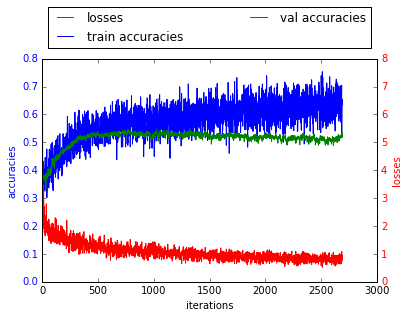

In [20]:
for hoc_num in xrange(1,10):
    print ('Training and testing predict_next_ast rnn on Hour of Code problem #{}'.format(hoc_num))
    full_train_test_run(hoc_num) 
    print ('='*100)